# pooling simulation
## model assumptions
- basic idea is to pool samples, test a pool, and then divide the pool into smaller pools
- if a pool tests positive, it is kept in the queue and split into two smaller pools
- if a pool tests negative, it and all its constituents are removed from the testing queue
- if a pool is reduced to a single sample, it is a terminal test, its result is taken to be the patient result

- a false positive rate of 1.0 relative to f and false negative rate of 0.1 are assumed

- assumed perfect apriori knowledge of the average rate of positive tests
- used this number to compute the expected number of positive samples in the total sample population
- this is necessary to determine the initial pool size, each pool should have on average 1 positive sample
- thus a population rate of 0.5 positive or higher will likely be super-critical, leading to more tests with the pooling method than simply testing every sample individually, since tests will be wasted on pools with many positive samples in each fraction
- basic binary division followed for each splitting 

In [88]:
def split_pool(pool):
    pool_size = len(pool)
    split_1 = pool[0:int(pool_size/2)]
    split_2 = pool[int(pool_size/2):]
    #print(len(split_1), len(split_2))
    return(split_1, split_2)

def run_test(samples, pool_dictionary):
    pool_result = 0
    false_positive = 0
    false_negative = 0
    for ID in samples:
        if pool_dictionary[ID] == 1:
            if random.random() < false_negative_rate:
                false_negative = 1
            else:
                pool_result = 1
        else:
            if random.random() < false_positive_rate:
                pool_result = 1 
                false_positive = 1
        if pool_result == 1 and false_negative == 1:
            false_negative = 0 #silent false negative since some other sample tested positive in the pool
    return pool_result, false_negative, false_positive

false_neg_rate  0.1
true pos rate 0.01
true pos rate 0.013877551020408163
true pos rate 0.017755102040816328
true pos rate 0.021632653061224492
true pos rate 0.025510204081632654
true pos rate 0.029387755102040815
true pos rate 0.03326530612244898
true pos rate 0.037142857142857144
true pos rate 0.041020408163265305
true pos rate 0.04489795918367347
true pos rate 0.048775510204081635
true pos rate 0.052653061224489796
true pos rate 0.056530612244897964
true pos rate 0.060408163265306125
true pos rate 0.06428571428571428
true pos rate 0.06816326530612245
true pos rate 0.07204081632653062
true pos rate 0.07591836734693877
true pos rate 0.07979591836734694
true pos rate 0.08367346938775509
true pos rate 0.08755102040816326
true pos rate 0.09142857142857143
true pos rate 0.09530612244897958
true pos rate 0.09918367346938775
true pos rate 0.10306122448979592
true pos rate 0.10693877551020407
true pos rate 0.11081632653061224
true pos rate 0.11469387755102041
true pos rate 0.1185714285714285

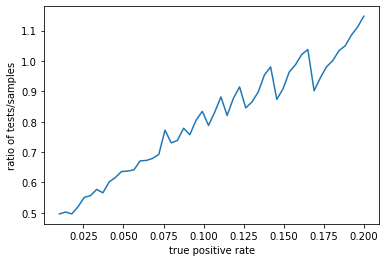

In [108]:
import numpy as np
import random
import matplotlib.pyplot as plt
import uuid
### initialize test pool ###

sizes = list(range(10,200,10))
false_negatives = np.zeros(len(sizes))
false_positives = np.zeros(len(sizes))
numbers_of_samples = np.zeros(len(sizes))
numbers_of_tests = np.zeros(len(sizes))
tests_to_samples = np.zeros(len(sizes))
true_positive_rate = 0.01345

global false_negative_rate

global false_positive_rate
# false_positive_rate = 0.01345
false_positive_rate = 0.1
false_negative_rates = np.linspace(0.1, 0.1,1)

for fp in range(0, len(false_negative_rates)):
    false_negative_rate = false_negative_rates[fp]
    print("false_neg_rate ",false_negative_rate)
    true_positive_rates = np.linspace(0.01, 0.2,50)
    test_efficiencies = np.zeros(len(true_positive_rates))
    for rate in range(0,len(true_positive_rates)):
        true_positive_rate = true_positive_rates[rate]
        print("true pos rate", true_positive_rate)
        for condition in range(0, len(sizes)):
            patient_samples = sizes[condition]**2

            

            grand_test_pool = np.zeros((patient_samples))
            ids_grand_pool = np.zeros((patient_samples),uuid.UUID)
            pool_dictionary = {}


            true_positives = 0
            positive_patients= []
            # positive_patients = random.choices(range(0,patient_samples),k=int(true_positive_rate*patient_samples))
            for i in range(0,patient_samples):
                ID = uuid.uuid4()
                ids_grand_pool[i] = ID
                if random.random() <= true_positive_rate:
                    true_positives += 1
                    grand_test_pool[i] = 1
                    pool_dictionary[ID] =1
                    positive_patients.append(i)
                else:
                    pool_dictionary[ID] =0

            #initial split
            guess_rate = true_positive_rate
            guess_average_multiplicity = patient_samples*guess_rate
            shannon_information = guess_rate * np.log2(guess_rate) 
    #         print(-2/shannon_information, " necessary binary divisions per positive case")


            main_queue = []
            split_size = int(1/guess_rate)
            for multiple in range(0, int(guess_average_multiplicity)):
                main_queue.append(ids_grand_pool[split_size*multiple:split_size*multiple+split_size])

    #         print("split size", split_size)
    #         print("average multiplicity", guess_average_multiplicity)
    #         print("initial queue size", len(main_queue))


            total_false_negatives, total_false_positives = 0,0
            MASTER_TEST_COUNTER = 0
            POSITIVE_IDS = 0
            while len(main_queue) > 0:

                if len(main_queue[0]) > 1:
                    pool_a, pool_b = split_pool(main_queue[0])    


                    MASTER_TEST_COUNTER += 1
                    main_queue.remove(main_queue[0])
                    A, afalse_positive, afalse_negative = run_test(pool_a, pool_dictionary)
                    if A == 1:
                        main_queue.append(pool_a)
                        if len(pool_a) == 1:
                            POSITIVE_IDS += 1
                            total_false_negatives += afalse_negative
                            total_false_positives += afalse_positive
                    else:
                        if len(pool_a) == 1:
                            total_false_negatives += afalse_negative
                            total_false_positives += afalse_positive


                    MASTER_TEST_COUNTER += 1
                    B, bfalse_positive, bfalse_negative = run_test(pool_b, pool_dictionary)
                    if B == 1:
                        main_queue.append(pool_b)
                        if len(pool_b) == 1:
                            POSITIVE_IDS += 1
                            total_false_negatives += bfalse_negative
                            total_false_positives += bfalse_positive
                    else:
                        if len(pool_b) == 1:
                            total_false_negatives += bfalse_negative
                            total_false_positives += bfalse_positive


                else:
                    MASTER_TEST_COUNTER += 1
                    C, cfalse_positive, cfalse_negative = run_test(main_queue[0], pool_dictionary)
                    total_false_negatives += cfalse_negative
                    total_false_positives += cfalse_positive
                    if C == 1:
                        POSITIVE_IDS += 1
        #                 print("+")
                    main_queue.remove(main_queue[0])
    #         print("total positive IDs: ", POSITIVE_IDS)        
    #         print("true positives: ", true_positives)
    #         print("number of tests: ", MASTER_TEST_COUNTER)
    #         print("number of samples: ", patient_samples)
    #         print("false positives: ", total_false_positives)
    #         print("false negatives: ", total_false_negatives)

            false_negatives[condition] = total_false_negatives
            false_positives[condition] = total_false_positives
            numbers_of_samples[condition] = patient_samples
            numbers_of_tests[condition] = MASTER_TEST_COUNTER
            tests_to_samples[condition] = MASTER_TEST_COUNTER/patient_samples

        test_efficiencies[rate] = np.mean(tests_to_samples)

    plt.plot(true_positive_rates, test_efficiencies)

plt.xlabel("true positive rate")
plt.ylabel("ratio of tests/samples" )
plt.show()
plt.close()